In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam,SGD,RMSprop


In [2]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)

Total samples: 23708


In [3]:
# limit
limit = 5000
if size > limit:
    files = files[:limit]



In [4]:
images = []
age = []
gender = []

for img_name in files:
    ages, genders = img_name.split("_")[:2]
    img = cv2.imread(os.path.join(path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(np.array(img))
    age.append(np.array(ages))
    gender.append(np.array(genders))

age = np.array(age, dtype=np.int64)
images = np.array(images)  
gender = np.array(gender, np.uint64)

In [5]:
# Skapar en DataFrame av datan
data = {
    'Age': age,
    'Gender': gender,
    'Image': images.tolist()  # convert images back to lists for DataFrame
}

df = pd.DataFrame(data)


# EDA

/tmp/ipykernel_75/2705801527.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'],kde=True, bins=30)


<Axes: xlabel='Age', ylabel='Density'>

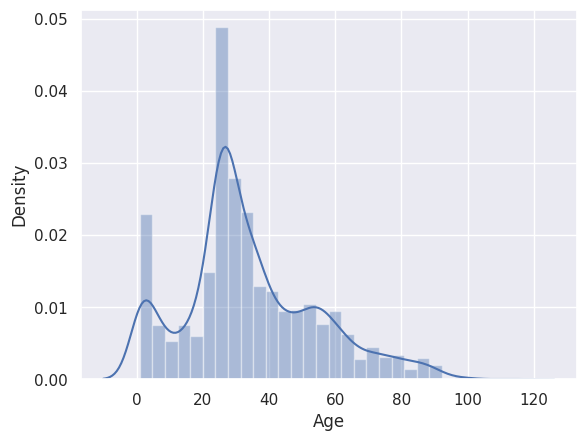

In [6]:
sns.set_theme()
sns.distplot(df['Age'],kde=True, bins=30)

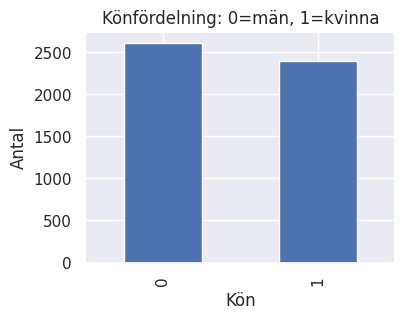

In [7]:
# gruppera data av kön och antal för varje kön
gender_counts = df['Gender'].value_counts()


plt.figure(figsize=(4, 3))
gender_counts.plot(kind="bar")
plt.xlabel('Kön')
plt.ylabel('Antal')
plt.title("Könfördelning: 0=män, 1=kvinna")

plt.show()

In [8]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42)

x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(images, gender, random_state=42)


In [9]:
len(x_train_age), len(x_test_age), len(y_train_age), len(y_test_age)

(3750, 1250, 3750, 1250)

### Age CNN model

In [10]:
age_model = Sequential()
age_model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(200,200,3)))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))
              
age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Conv2D(512, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Flatten())
age_model.add(Dropout(0.2))
age_model.add(Dense(512, activation='relu'))

age_model.add(Dense(1, activation='linear', name='age'))

In [11]:
age_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#print(age_model.summary())              


Eftersom vi vill att modellen ska förutsäga ålder och därav används regressionsproblem eftersom ålder är en kontinuerlig variabel, ålder kan var vilket tal som helst. Regressionmodeller används för att hantera kontinerliga data. 
Vid regressionmodeller som ålder i detta fall kommer loss function, dvs det som vi vill att modellen ska minimera , är mean squared error. Vi använder som vanlig adam optimizer. 


In [12]:
history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_test_age, y_test_age), epochs=30)

Epoch 1/30
118/118 [==============================] - 664s 6s/step - loss: 284861.5312 - mae: 66.4470 - val_loss: 539.2725 - val_mae: 17.1962
Epoch 2/30
118/118 [==============================] - 662s 6s/step - loss: 441.9184 - mae: 16.2097 - val_loss: 471.6943 - val_mae: 17.9657
Epoch 3/30
118/118 [==============================] - 662s 6s/step - loss: 375.3593 - mae: 14.9157 - val_loss: 370.7984 - val_mae: 14.5708
Epoch 4/30
118/118 [==============================] - 661s 6s/step - loss: 342.9524 - mae: 14.2764 - val_loss: 397.7440 - val_mae: 14.3134
Epoch 5/30
118/118 [==============================] - 659s 6s/step - loss: 300.7138 - mae: 13.3352 - val_loss: 305.4626 - val_mae: 12.6515
Epoch 6/30
118/118 [==============================] - 660s 6s/step - loss: 271.2451 - mae: 12.5686 - val_loss: 277.8905 - val_mae: 13.1927
Epoch 7/30
118/118 [==============================] - 661s 6s/step - loss: 253.2950 - mae: 12.2099 - val_loss: 252.8198 - val_mae: 12.0699
Epoch 8/30
118/118 [====

In [13]:
age_model.save('age_model.h5')

### Gender base CNN model

In [14]:
gender_model = Sequential()

gender_model.add(Conv2D(36, kernel_size=3, activation='relu', input_shape=(200,200,3)))

gender_model.add(MaxPool2D(pool_size=3, strides=2))
gender_model.add(Conv2D(64, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(128, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(256, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(512, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(512, activation='relu'))
gender_model.add(Dense(1, activation='sigmoid', name='gender'))


In [15]:
gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history_gender = gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_test_gender, y_test_gender), epochs=30)

Epoch 1/30
118/118 [==============================] - 282s 2s/step - loss: 2.2091 - accuracy: 0.6227 - val_loss: 0.6581 - val_accuracy: 0.6656
Epoch 2/30
118/118 [==============================] - 278s 2s/step - loss: 0.5462 - accuracy: 0.7397 - val_loss: 0.8742 - val_accuracy: 0.6496
Epoch 3/30
118/118 [==============================] - 278s 2s/step - loss: 0.5112 - accuracy: 0.7560 - val_loss: 0.5077 - val_accuracy: 0.7560
Epoch 4/30
118/118 [==============================] - 275s 2s/step - loss: 0.4475 - accuracy: 0.7907 - val_loss: 0.4749 - val_accuracy: 0.7744
Epoch 5/30
118/118 [==============================] - 276s 2s/step - loss: 0.4133 - accuracy: 0.8128 - val_loss: 0.5030 - val_accuracy: 0.7672
Epoch 6/30
118/118 [==============================] - 275s 2s/step - loss: 0.4274 - accuracy: 0.7965 - val_loss: 0.4899 - val_accuracy: 0.7744
Epoch 7/30
118/118 [==============================] - 278s 2s/step - loss: 0.3916 - accuracy: 0.8275 - val_loss: 0.3860 - val_accuracy: 0.8280

In [23]:
gender_model.save('gender_model.h5')

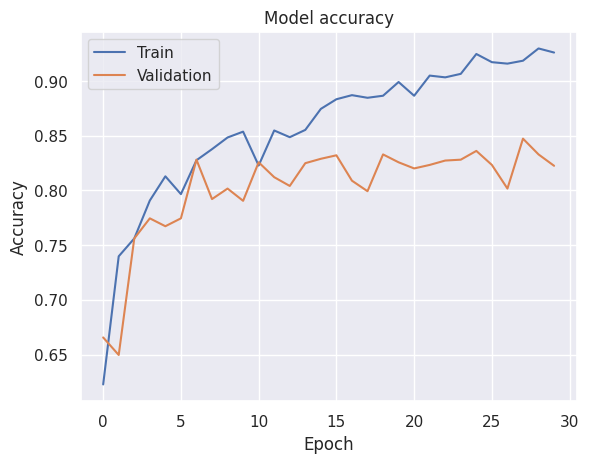

In [25]:
#Model accuracy
plt.plot(history_gender.history['accuracy'])
plt.plot(history_gender.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

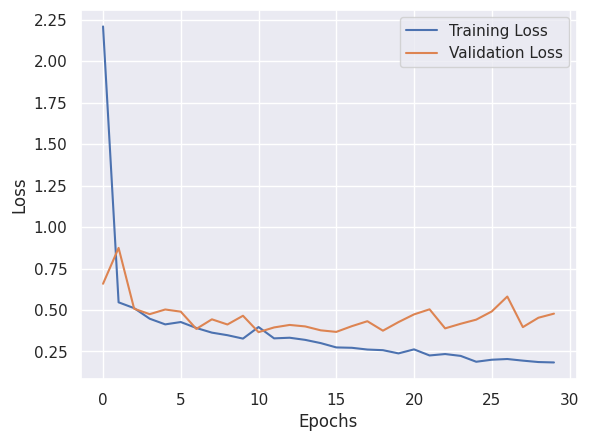

In [26]:
# jämför loss
plt.plot(history_gender.history['loss'], label='Training Loss')
plt.plot(history_gender.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss')  
plt.legend()
plt.show()